# Classificação por Modelos Não-Paramétricos

Sistemas baseados em regras têm um problema bastante sério: eles dependem da construção de regras. Pode ser interessante, para diversos problemas, que os critérios de classificação sejam aprendidos automaticamente pelo sistema. Neste caderno, utilizaremos 

# Objetivos

Ao final desta iteração, o aluno será capaz de:
* Entender o conceito de *aprendizado supervisionado*
* Entender o conceito de *generalização*
* Entender sistemas de aprendizado tipo K Nearest Neighbors
* Construir conjuntos de treinamento e teste
* Analisar, através de processos Monte Carlo, a robustez de sistemas de aprendizado
* Utilizar o pacote Python para classificação por KNN



In [1]:
# Inicializacao
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# K Vizinhos mais Próximos (K Nearest Neighbors - KNN)

KNN é um algoritmo não-paramétrico que funciona da seguinte forma. Na *fase de treinamento* (fit), o sistema classificador recebe como entrada um conjunto de elementos rotulados da base de dados. Na *fase de teste* (predict), o sistema encontra o rótulo dos K vizinhos (dentre os elementos recebidos no treinamento) mais próximos de cada elemento recebido como entrada, e então retorna o rótulo mais frequente nesses vizinhos.

Trata-se de um algoritmo bastante conhecido, implementado no módulo [scikit-learn](http://scikit-learn.org/stable/modules/neighbors.html) do Python. Por favor, altere o código abaixo até se sentir confortável com os métodos fit() e predict() do classificador. Como exercício, modifique o código para que as entradas tenham mais de uma dimensão, e tente predizer o que acontece ao variar o número K de vizinhos avaliados.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

X = [[0], [1], [2], [3], [4]];
y = ['V', 'V', 'F', 'F', 'F'];
neigh = KNeighborsClassifier(n_neighbors=3); # n_neighbors = K

neigh.fit(X, y);
print neigh.predict([ [1.3], [1.7], [1.5]])

['V' 'F' 'V']


# Condicionando dados para serem abertos pelo scikit-learn

Veja que o sklearn.neighbors recebe como entrada um conjunto de dados num formato que não é o mesmo que temos usado até o momento. Então, precisaremos representar nossos dados de uma forma compatível com o que o módulo requer - uma lista de N listas, sendo que cada uma dessas N listas é um vetor de dados. O código para abrir a base de dados, então, fica:

In [3]:
# Abrindo conjunto de dados
import csv
with open("biometria.csv", 'rb') as f:
    dados = list(csv.reader(f))
    
rotulos_volei = [d[0] for d in dados[1:-1] if d[0] is 'V']
rotulos_futebol = [d[0] for d in dados[1:-1] if d[0] is 'F']
altura_volei = [[float(d[1])] for d in dados[1:-1] if d[0] is 'V']
altura_futebol = [[float(d[1])] for d in dados[1:-1] if d[0] is 'F']
peso_volei = [[float(d[2])] for d in dados[1:-1] if d[0] is 'V']
peso_futebol = [[float(d[2])] for d in dados[1:-1] if d[0] is 'F']

O próprio KNeighborsClassifier já implementa um método que verifica o índice de acertos de um processo de classificação. O método recebe como entrada vetores que serão classificados e um conjunto de rótulos-gabarito correspondentes. Assim, o usuário fica isento de implementar essas funções e podemos escrever todo nosso processo de classificação na forma:

In [ ]:
classificador = KNeighborsClassifier(n_neighbors=3); # n_neighbors = K
classificador.fit(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol);
score = classificador.score(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol)
print "Acertos:", int(score * len(altura_volei + altura_futebol))

# Sobre-ajuste do modelo e conjuntos de treino-teste

Mas, perceba que há algo errado. Na etapa de treinamento do nosso sistema, fornecemos a ele todos os nossos dados rotulados. Depois, na etapa de teste, verificamos quais pontos estão próximos deles mesmos - ou seja, estamos avaliando se o sistema que fizemos é capaz de classificar os próprios dados que foram usados para treiná-lo.

Os resultados que tivemos, portanto, não permitem inferir se nosso sistema é capaz de generalizar o resultado. Em outras palavras, não mostramos que o sistema faz muito mais que reproduzir seus dados de treino. Podemos dizer que nosso sistema pode ter sido sobre-ajustado (ou, que sofreu *over-fitting*), e, portanto, só demonstramos funciona sobre os dados que foram usados em seu treinamento.

Um sistema sobre-ajustado tem pouca capacidade de generalização, ou seja, os resultados obtidos para o conjunto de teste não extrapolam para dados adicionais. Para evitar o sobre-ajuste, é preciso construir bases de dados diferentes para as quais executaremos procedimentos de treinamento e de teste. Esse procedimento é chamado de validação.

Existem muitas maneiras de dividir a base de dados. Podemos, por exemplo, escolher aleatoriamente uma fração dos dados para compor a base de treinamento e usar os dados restantes como base de teste. Esse procedimento está implementado no scikit-learn, de forma que não precisamos nos preocupar (muito) com seu funcionamento interno.

In [5]:
# Validacao usando divisao aleatoria do conjunto de dados
from sklearn.cross_validation import train_test_split

dados_treino, dados_teste, rotulos_treino, rotulos_teste =\
    train_test_split(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol, train_size=.3)

classificador = KNeighborsClassifier(n_neighbors=5); # n_neighbors = K
classificador.fit(dados_treino, rotulos_treino);
score = classificador.score(dados_teste, rotulos_teste);
print "% de Acertos:", 100*score

% de Acertos: 83.8709677419


Ao variar o parâmetro train_size, alteramos a fração dos dados que será utilizada para treinamento. Uma quantidade muito grande de dados de treino implica num teste menos significativo, mas pode aumentar a quantidade de acertos do sistema. Além disso, como os conjuntos são divididos aleatoriamente, duas execuções seguidas do mesmo código podem levar a resultados diferentes.

É interessante que verifiquemos a robustez do nosso sistema de classificação, ou seja, a variância que podemos esperar em seus resultados. Faremos isso através de um procedimento chamado Monte Carlo, que consiste em executar diversas vezes processo em questão e então analisar numericamente os resultados. Para a avaliação do nosso sistema, estamos interessados em evidenciar a média e a variância do número de acertos de nosso sistema para diferentes tamanhos do conjunto de treinamento.

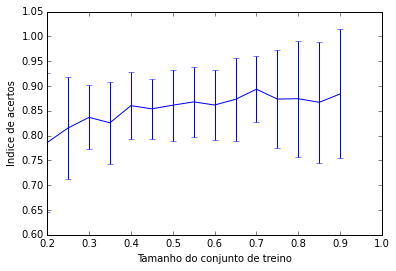

In [6]:
# Parametros para executar busca exaustiva
train_size_min = 0.2
train_size_max = 0.95
train_size_step = 0.05

# Numero de iteracoes para cada tamanho de conjunto de treino
n_iter = 100

# Listas que armazenarao os resultados
steps = []
medias = []
variancias = []

train_size_atual = train_size_min
while train_size_atual <= train_size_max: # para cada tamanho do conjunto de treino
    acertos = []
    for k in xrange(n_iter): # para cada iteracao do processo Monte Carlo
        dados_treino, dados_teste, rotulos_treino, rotulos_teste =\
            train_test_split(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol, train_size=train_size_atual)
            
        classificador = KNeighborsClassifier(n_neighbors=4); # n_neighbors = K
        classificador.fit(dados_treino, rotulos_treino);
        score = classificador.score(dados_teste, rotulos_teste);
        acertos.append(score)
    
    steps.append(train_size_atual)
    medias.append(np.mean(np.array(acertos)))
    variancias.append(np.std(np.array(acertos)))
    
    train_size_atual += train_size_step


plt.figure();
plt.errorbar(steps, medias, yerr=variancias);
plt.ylabel('Indice de acertos');
plt.xlabel('Tamanho do conjunto de treino');

A grande variância do índice de acertos mostra que o modelo que escolhemos é muito sensível aos dados de treinamento, ou seja, dados de treinamento diferentes levam a resultados muito diferentes. Assim, dizemos que o modelo KNN, para esta aplicação, não foi eficaz no sentido de *generalizar* seus resultados. Nas próximas lições, verificaremos como podemos construir modelos mais robustos para este mesmo problema.

# Exercícios

1. Desenhe um fluxograma que representa o processo de aprendizado supervisionado e teste do sistema, mostrando como os dados de entrada são divididos e como são utilizados no processo de treinamento e teste.
2. Observando os dados do problema, escolha um ponto que representa cada classe e que poderia implicar em bons resultados na classificação usando KNN.
3. Observando os dados do problema, escolha um ponto que representa cada classe de tal forma que os resultados da classificação usando KNN sejam ruins.
